In [1]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.vis import *
from model import PoseModel
from transform import *
from dataset import PlanktonDataset
import cPickle as pickle
from scipy.spatial.distance import euclidean

%matplotlib inline

In [2]:
img_dir = '/data5/Plankton_wi18/rawcolor_db2/images'
csv_filename = '/data5/lekevin/plankton/poseprediction/data2/data_{}.csv'

phases = ['train', 'valid', 'test']

# dataset_mean, dataset_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
normalize = Normalize([0.5, 0.5, 0.5], [1, 1, 1])

batch_size = 16

input_size = (384, 384)

_GPU = 1

In [3]:
data_transform = {
    'train': transforms.Compose([
        Rescale(input_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ])
}

datasets = {x: PlanktonDataset(csv_file=csv_filename.format(x),
                               img_dir=img_dir,
                               transform=data_transform[x])
            for x in phases}

dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size,
                             shuffle=False, num_workers=4)
               for x in phases}

dataset_sizes = {x: len(datasets[x]) for x in phases}

use_gpu = torch.cuda.is_available()

In [4]:
modelName = 'vgg16'
modelRoot = '/data3/ludi/plankton_wi17/pose/poseprediction_torch/best_models'
model = PoseModel(modelName)
# model = nn.DataParallel(model)  #TODO modify for AlexNet
model = model.cuda(_GPU)
checkpoints = torch.load(modelRoot + '/{}/checkpoints/model_best.pth.tar'.format(modelName))
model.load_state_dict(checkpoints['state_dict'])

In [29]:
def evalShowArrow1(image, predcoordinates, gtruthcoordinates, cls):
    if isinstance(image, (np.ndarray, list)):
        image = np.copy(image)
    elif isinstance(image, torch.FloatTensor):
        image = (image.numpy()).transpose((1, 2, 0)).copy()

    if isinstance(gtruthcoordinates, torch.FloatTensor):
        gtruthcoordinates = gtruthcoordinates.numpy()
    
    # Calculate euclidean
    headEuclid = euclidean(predcoordinates[0], np.array([gtruthcoordinates[0],gtruthcoordinates[1]]))
    tailEuclid = euclidean(predcoordinates[1], np.array([gtruthcoordinates[2],gtruthcoordinates[3]]))
    avgEuclid = 0.5*(headEuclid + tailEuclid)
    
    height, width = image.shape[:2]
    predhead = (int(predcoordinates[0,0] * width), int(predcoordinates[0,1]*height))
    predtail = (int(predcoordinates[1,0] * width), int(predcoordinates[1,1]*height))

    gtruthhead = (int(gtruthcoordinates[0] * width), int(gtruthcoordinates[1] * height))
    gtruthtail = (int(gtruthcoordinates[2] * width), int(gtruthcoordinates[3] * height))
       
    cv2.arrowedLine(image, gtruthtail, gtruthhead, (1., 0., 0.), 3)
    cv2.arrowedLine (image, predtail, predhead, (0., 0., 1.), 3)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Head:{:.03f}\n Tail:{:.03f}\n Avg:{:.03f}'.format(headEuclid, tailEuclid, avgEuclid))
    plt.pause(0.001)

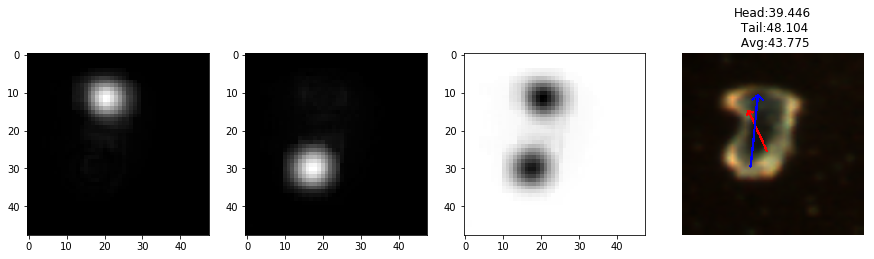

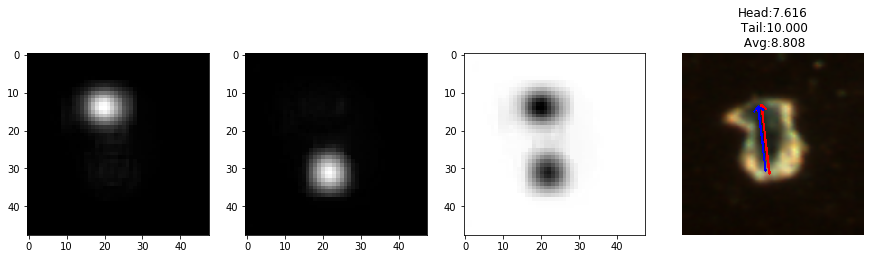

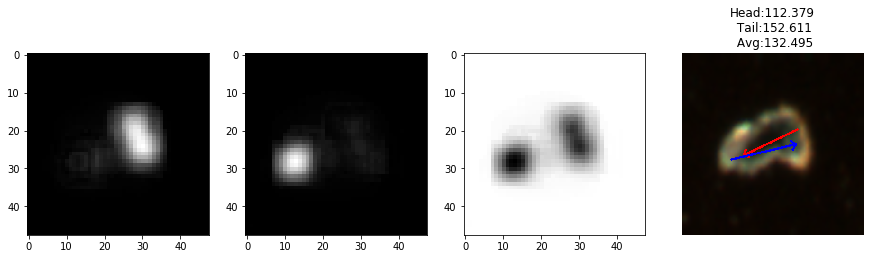

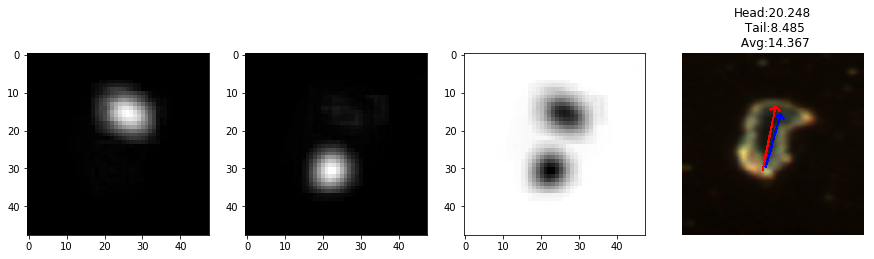

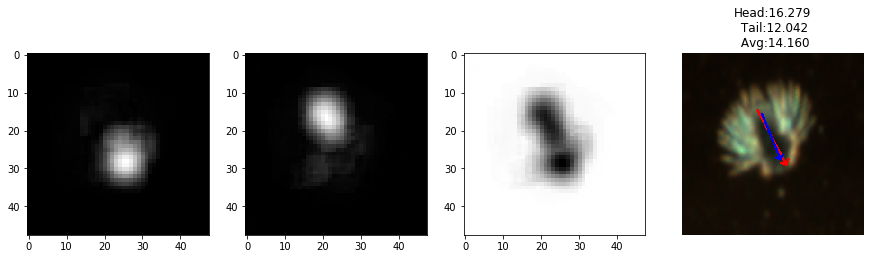

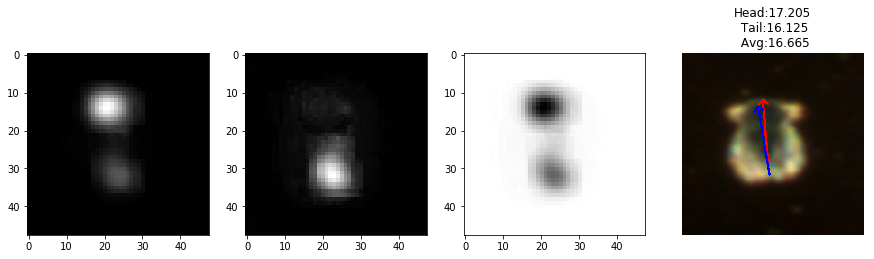

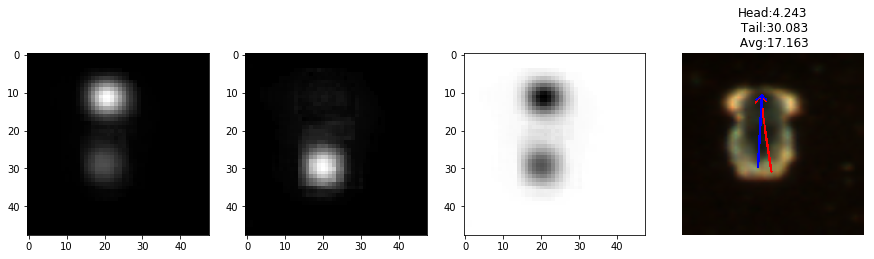

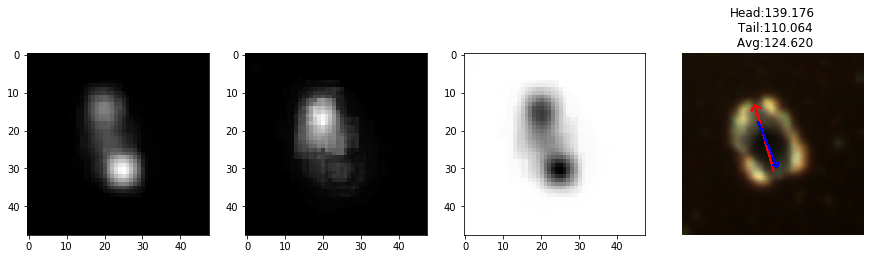

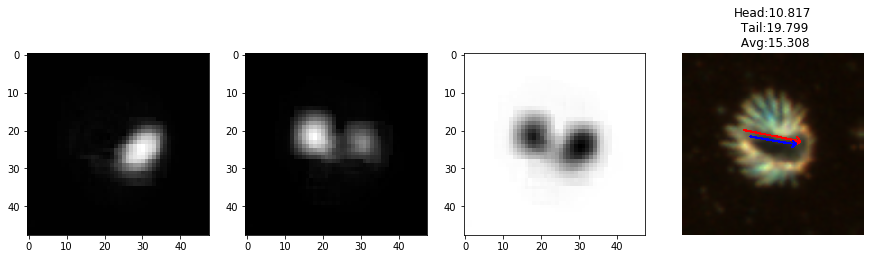

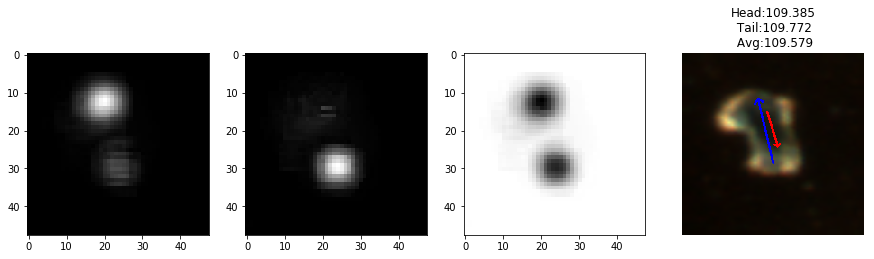

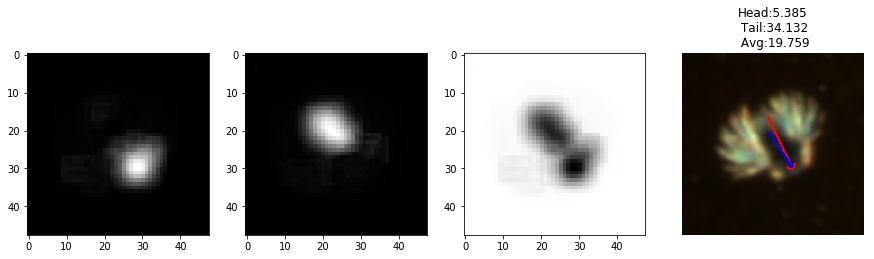

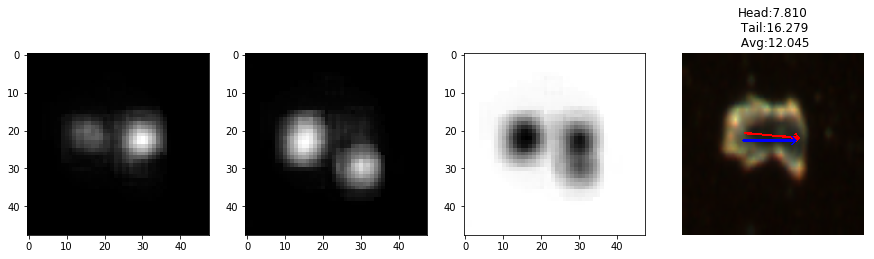

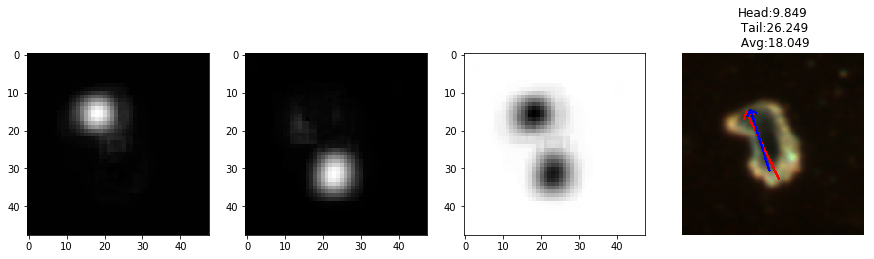

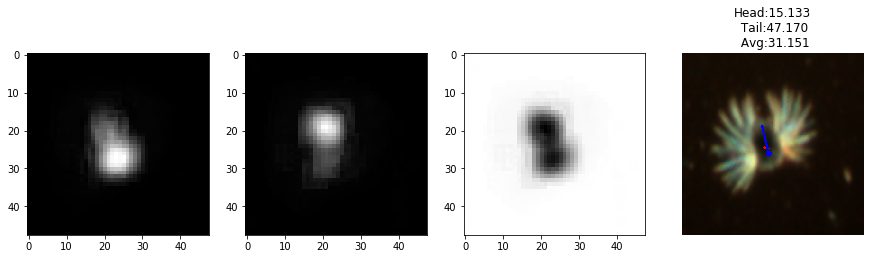

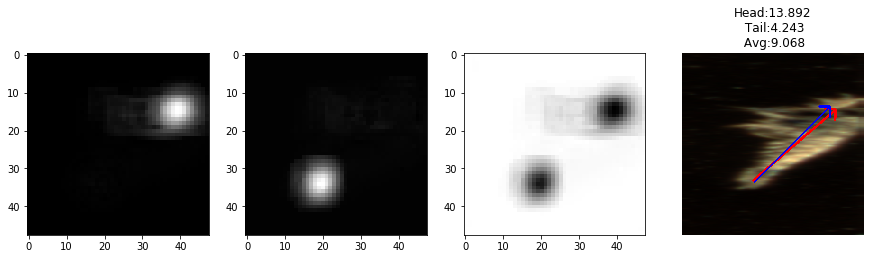

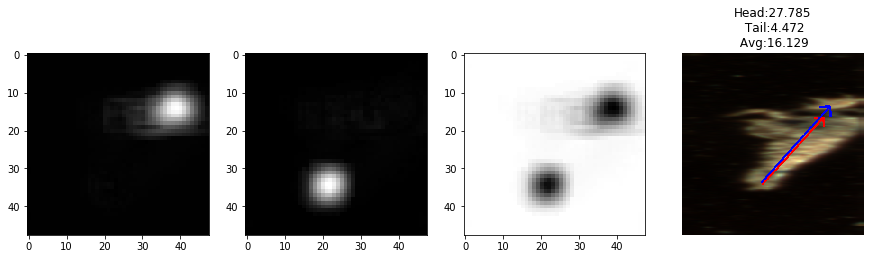

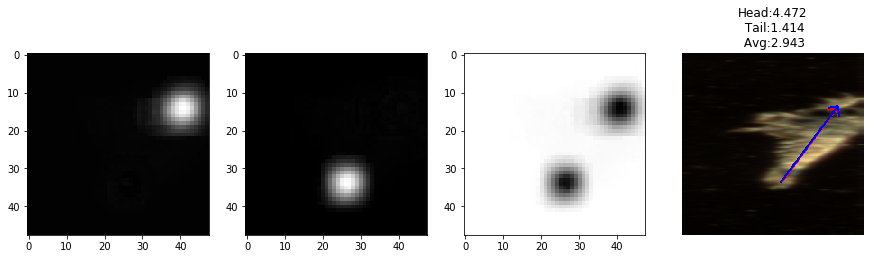

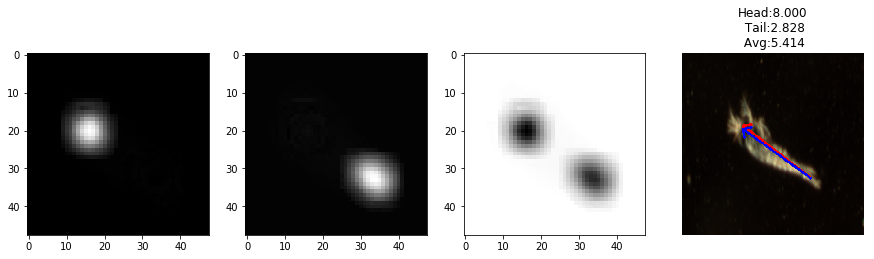

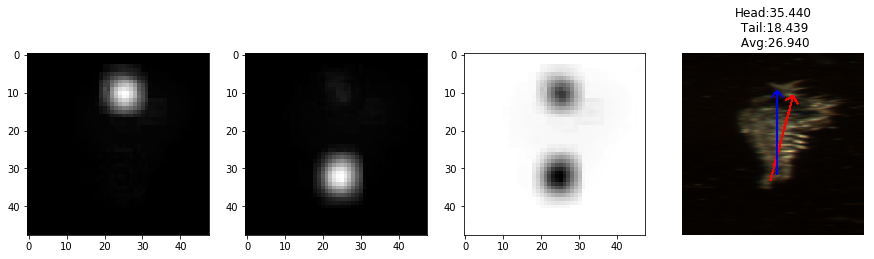

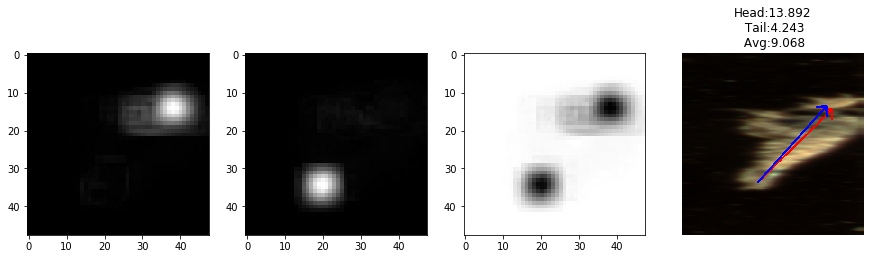

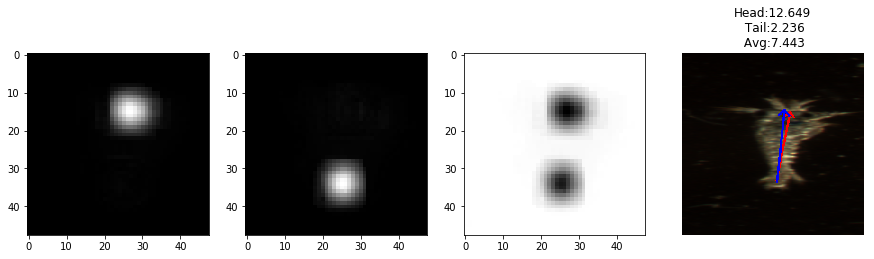

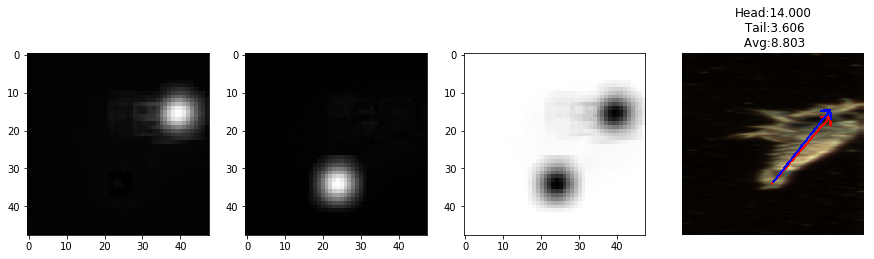

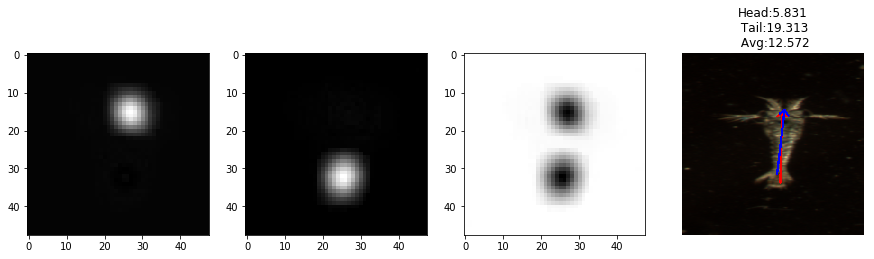

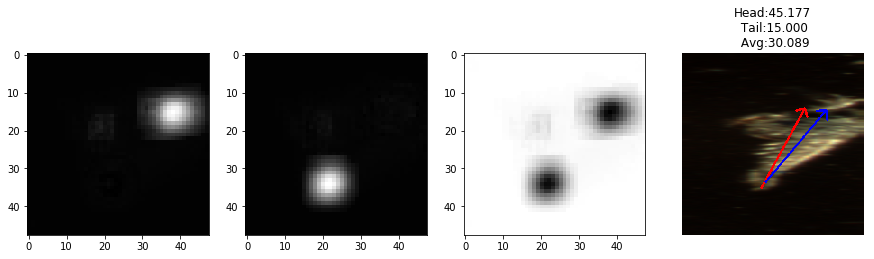

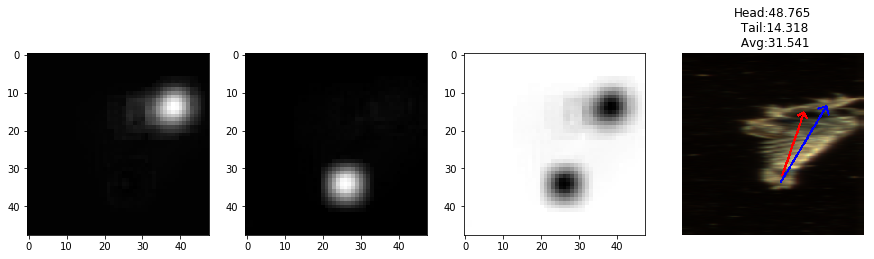

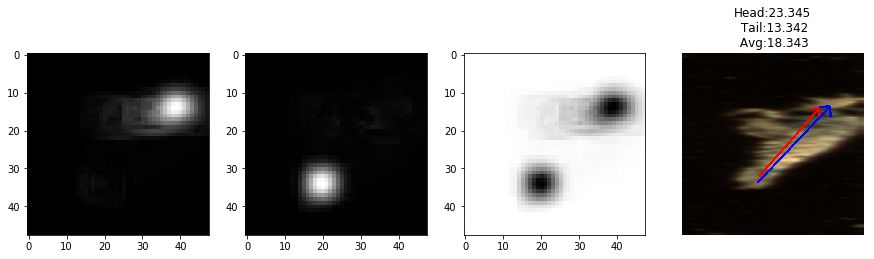

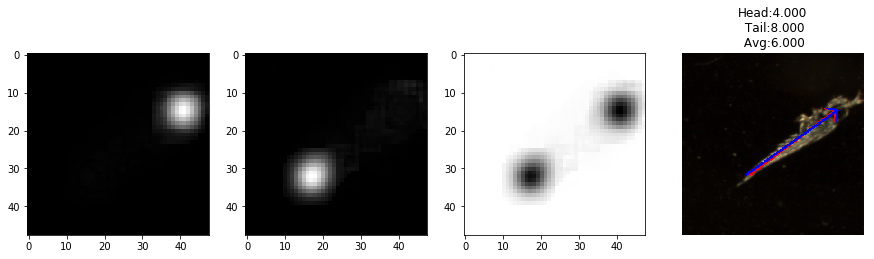

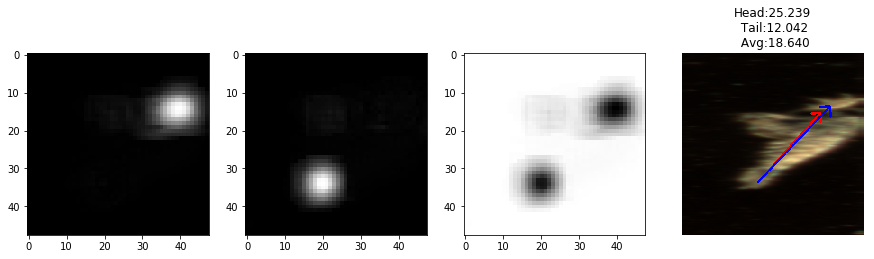

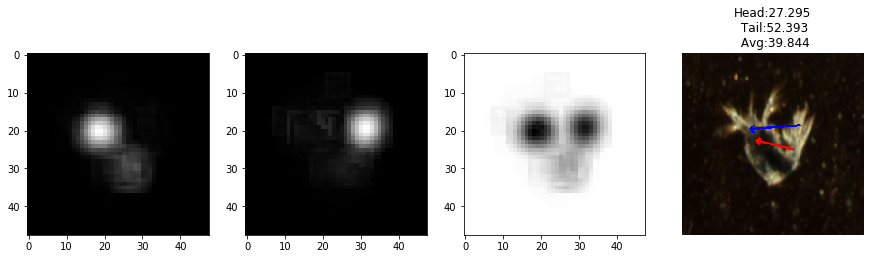

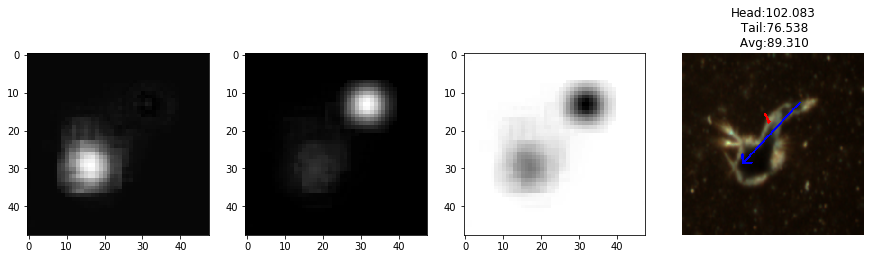

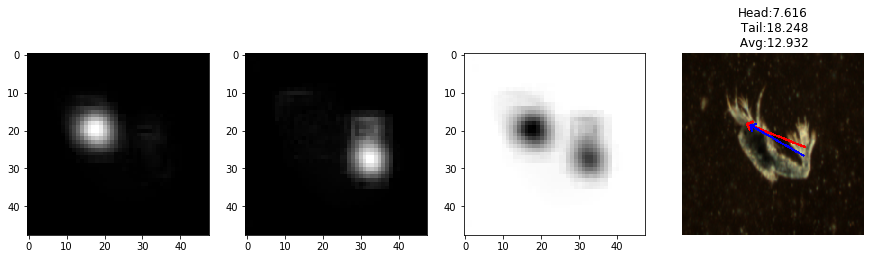

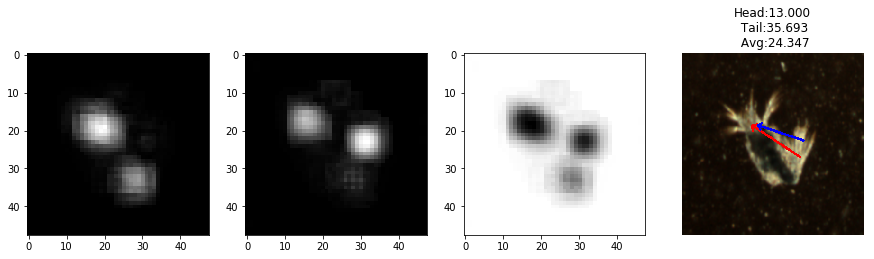

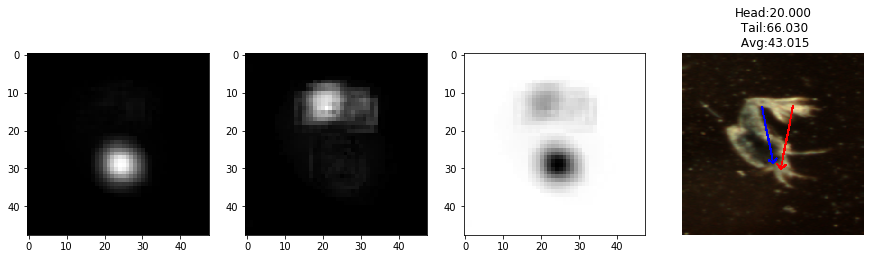

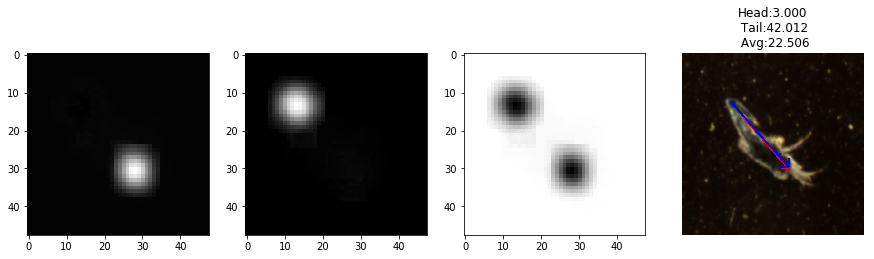

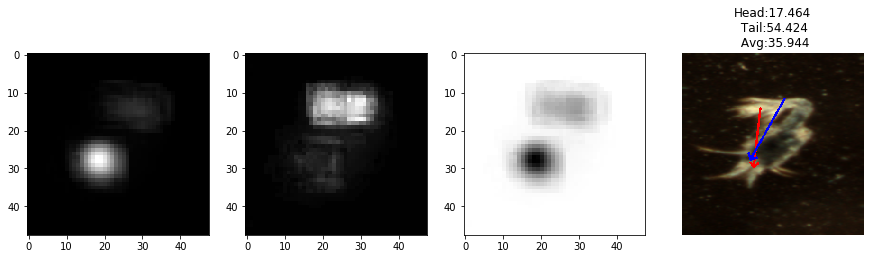

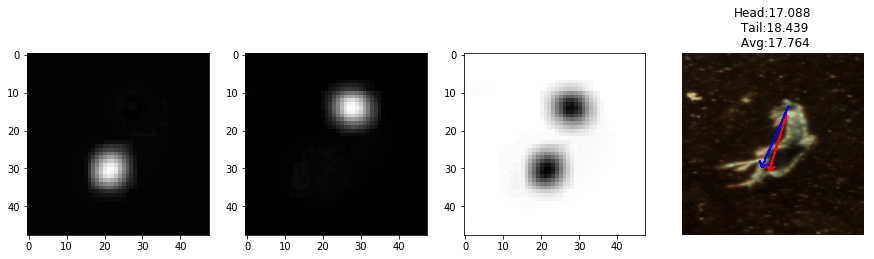

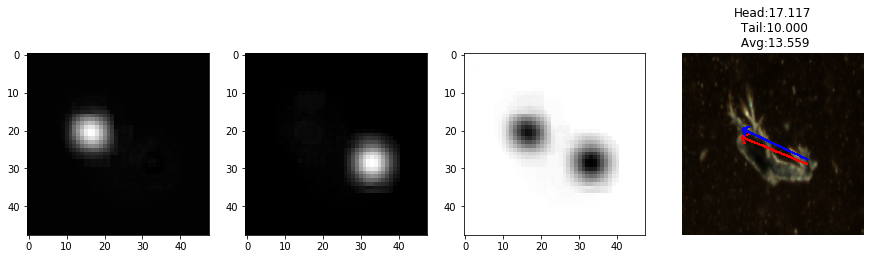

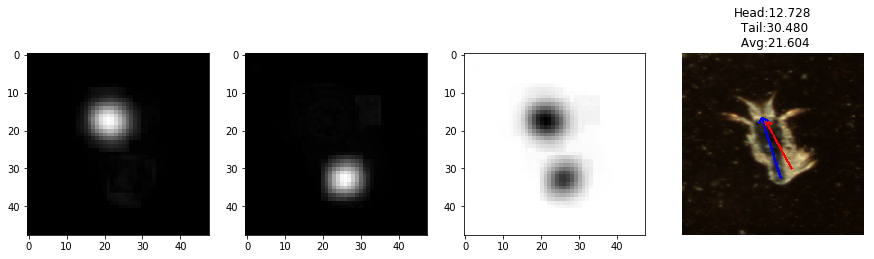

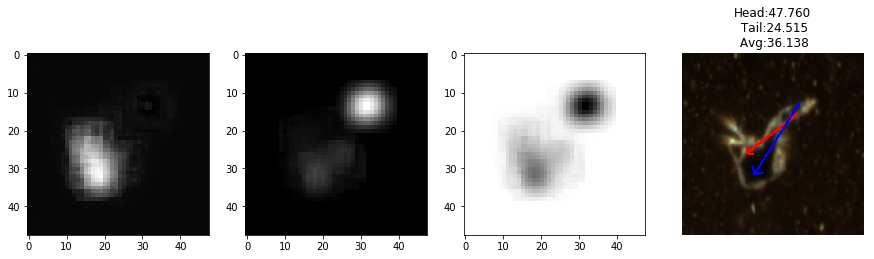

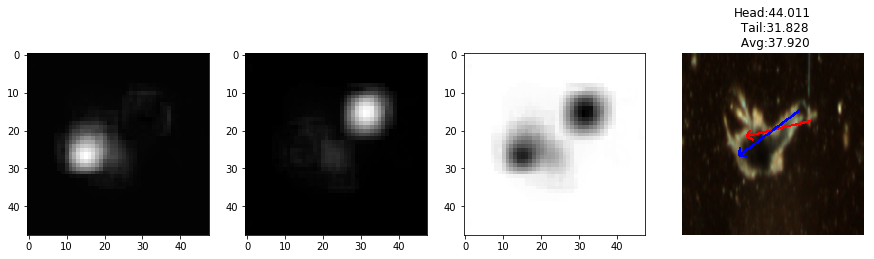

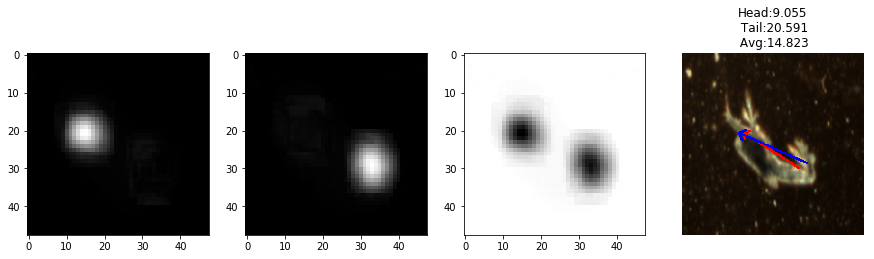

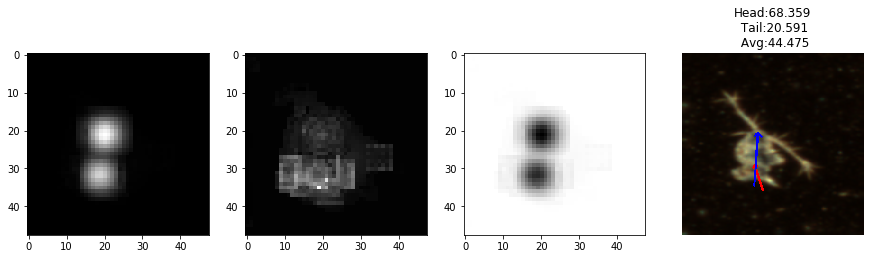

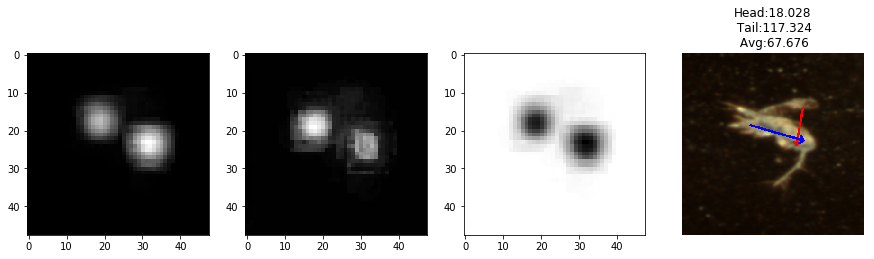

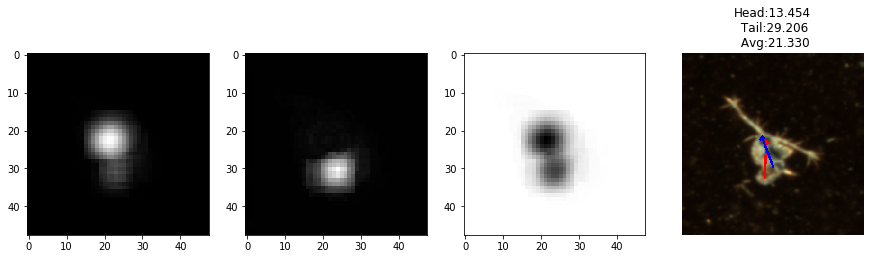

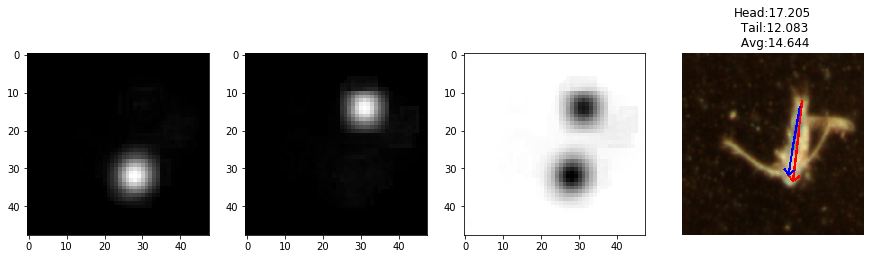

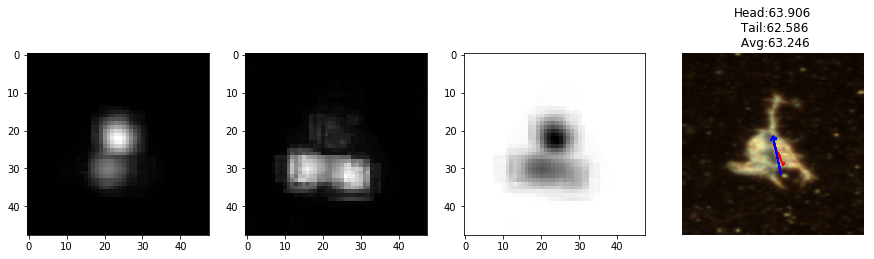

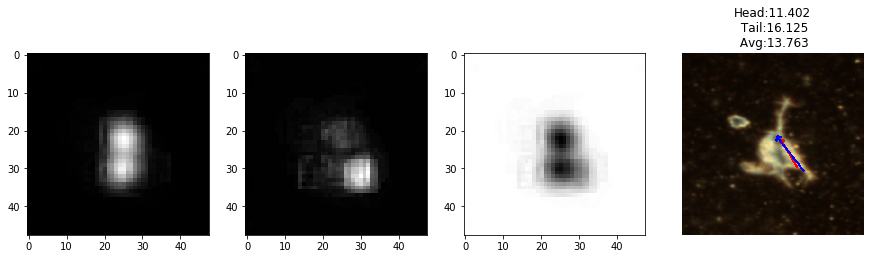

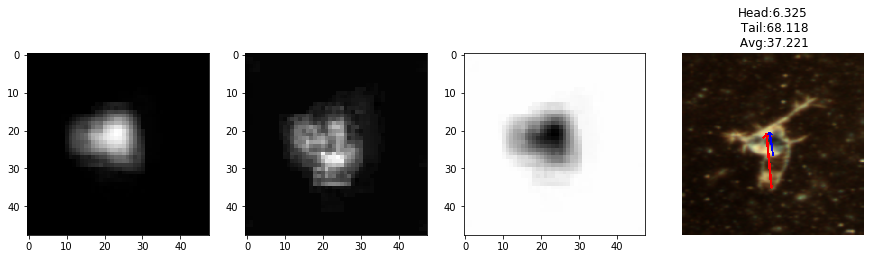

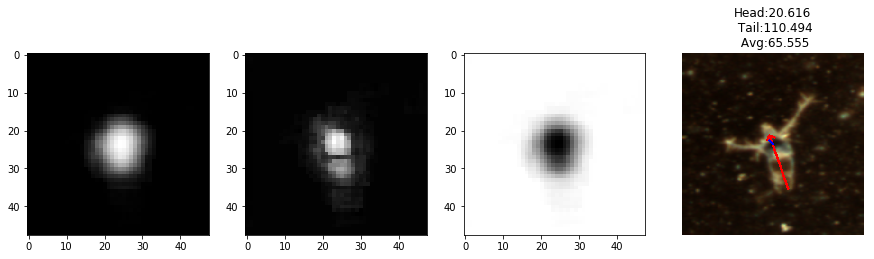

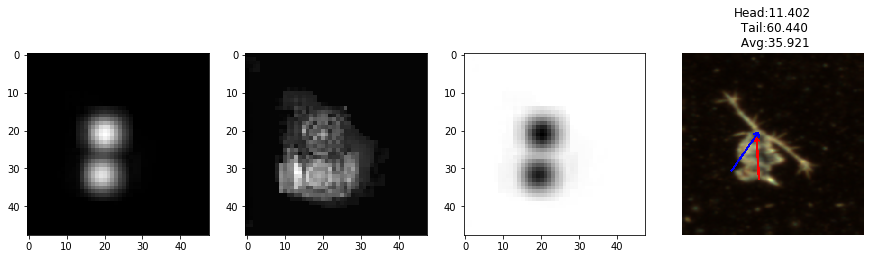

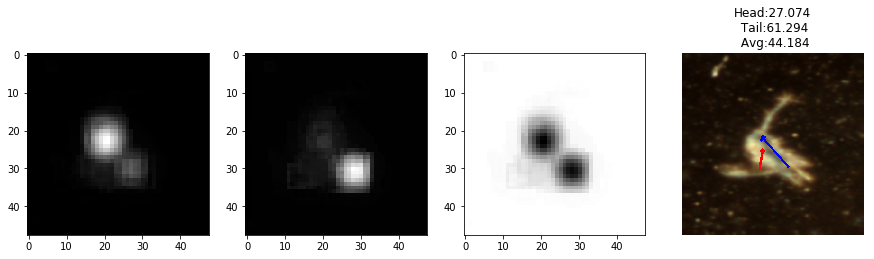

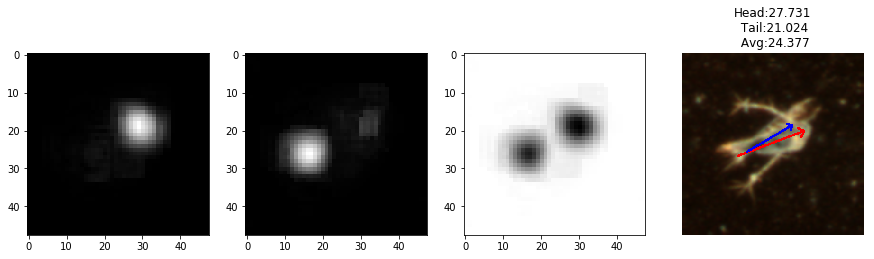

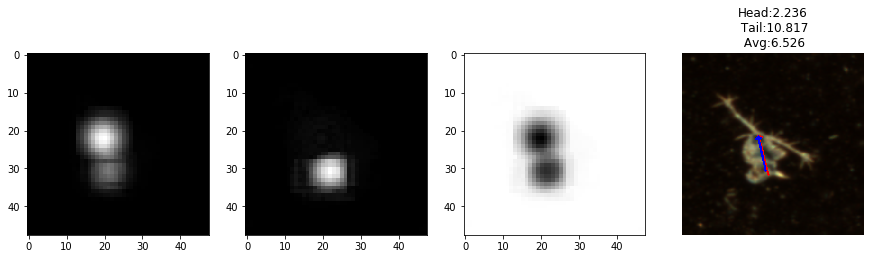

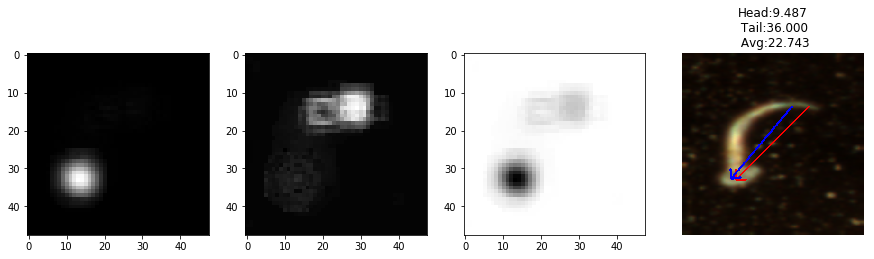

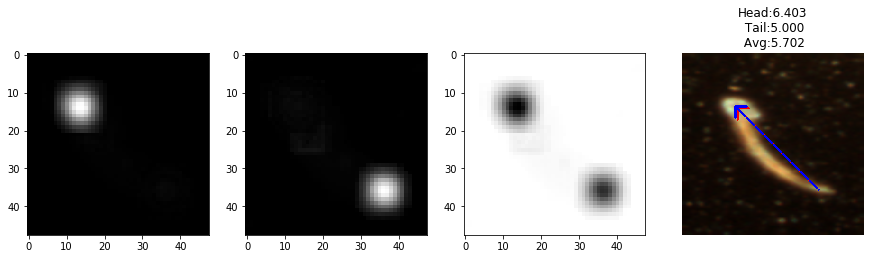

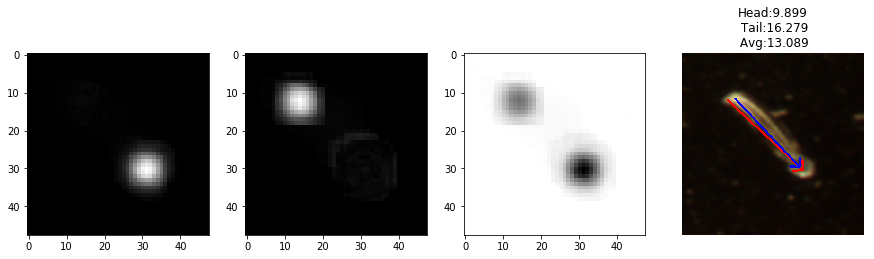

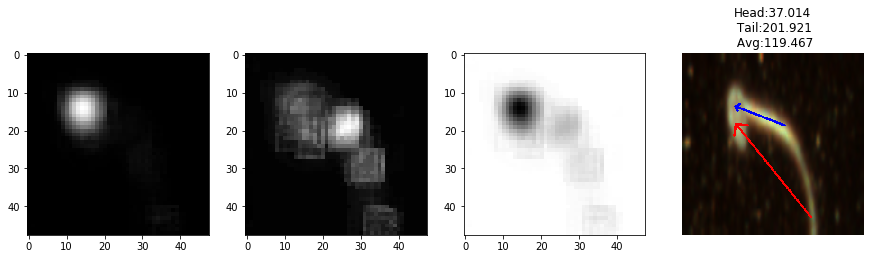

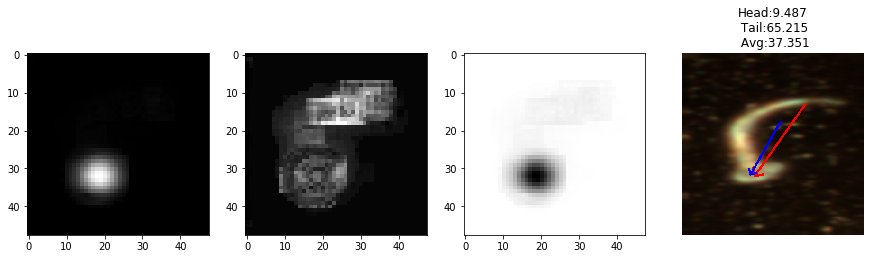

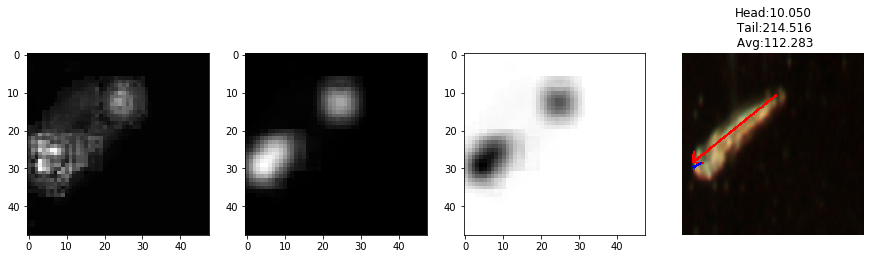

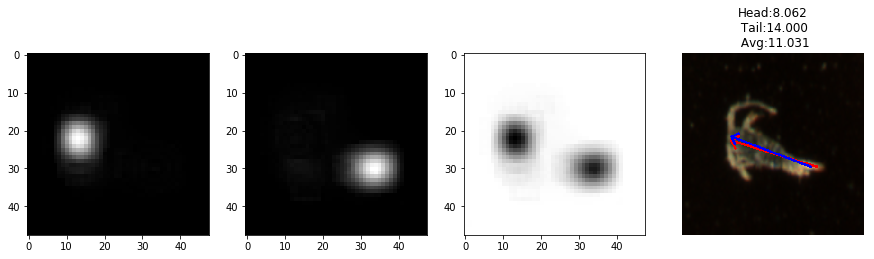

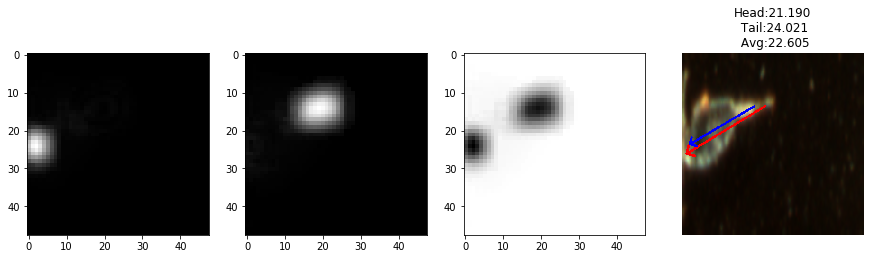

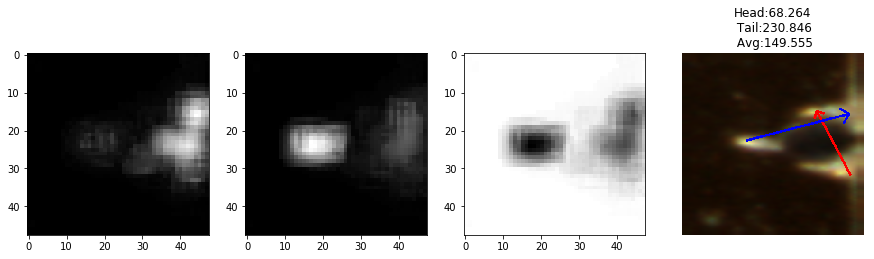

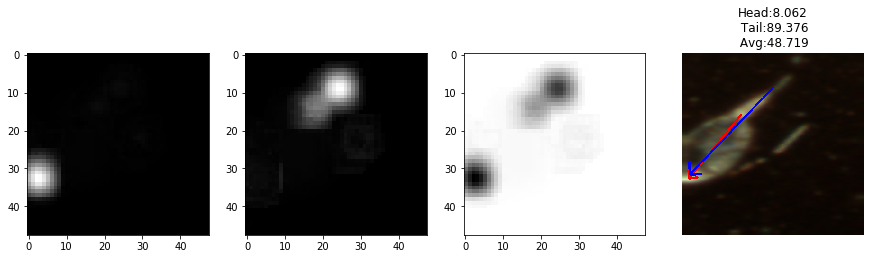

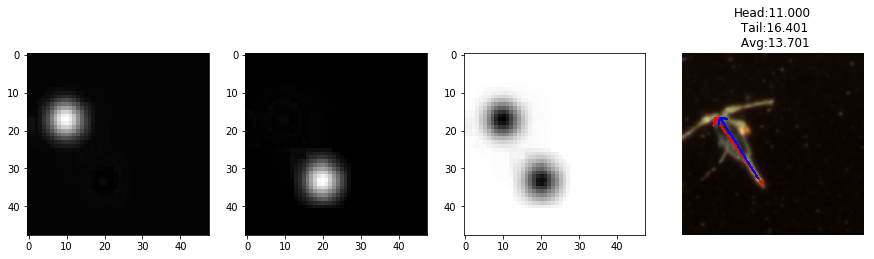

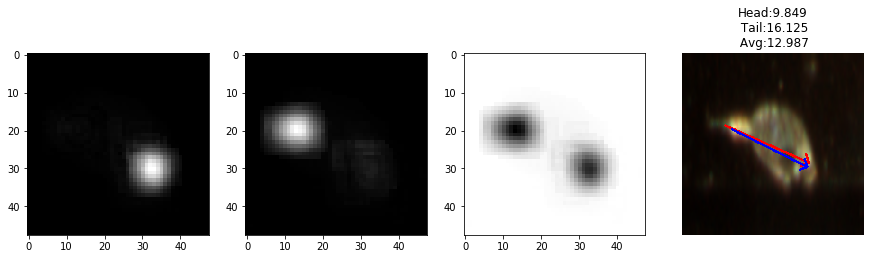

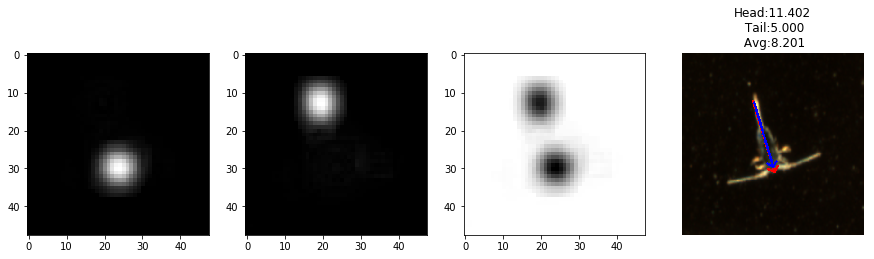

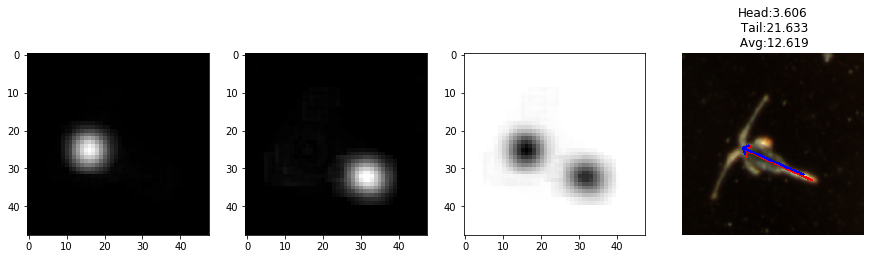

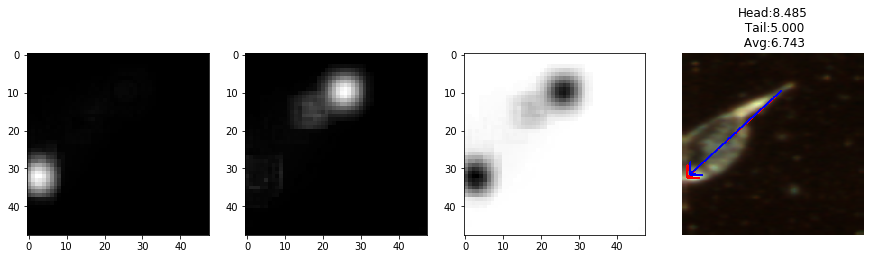

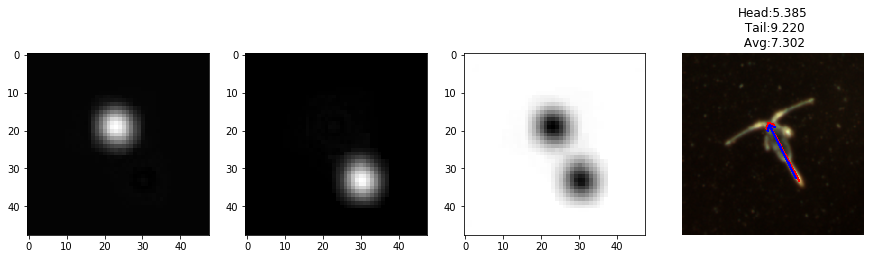

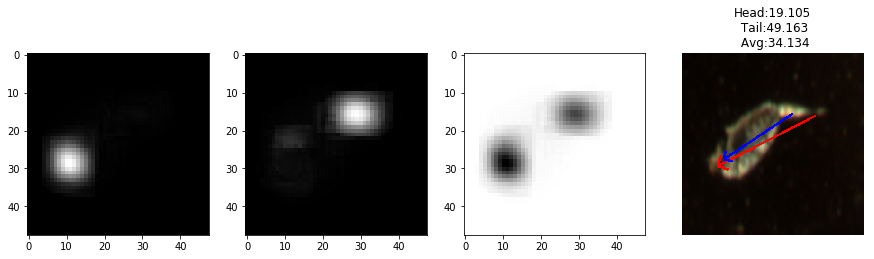

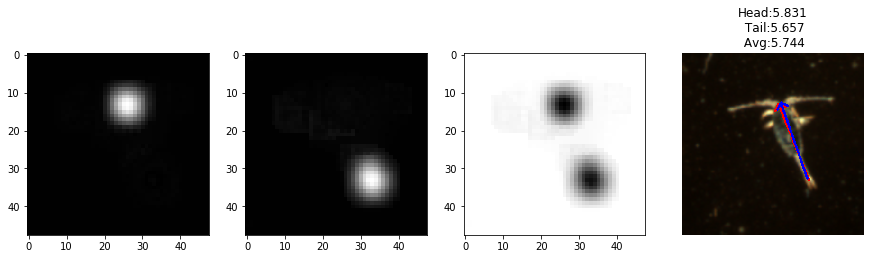

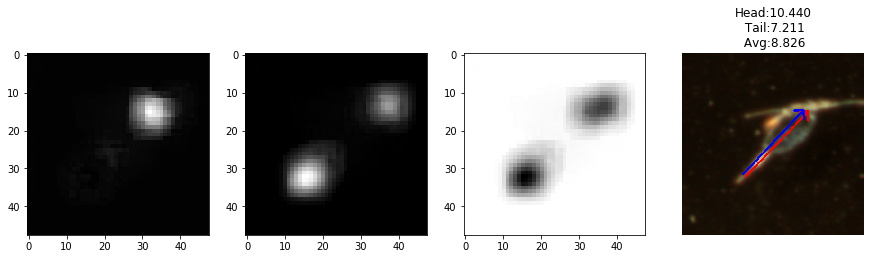

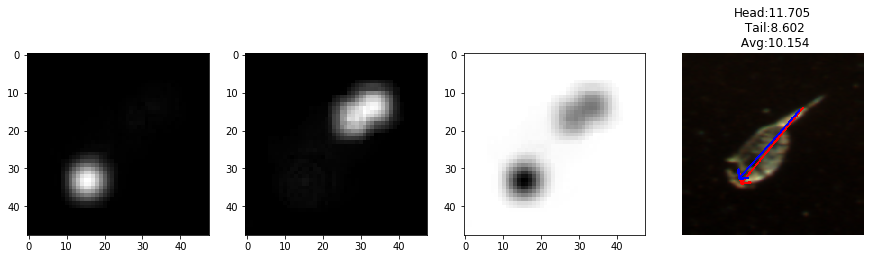

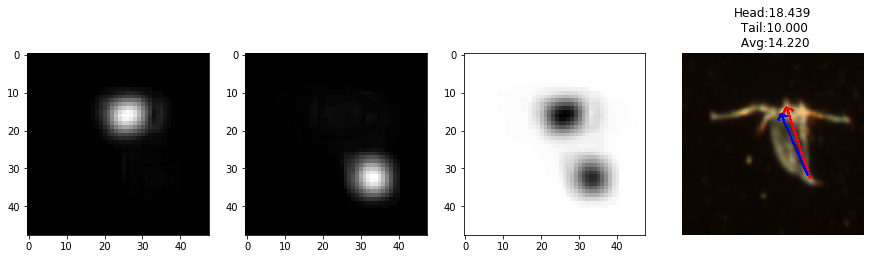

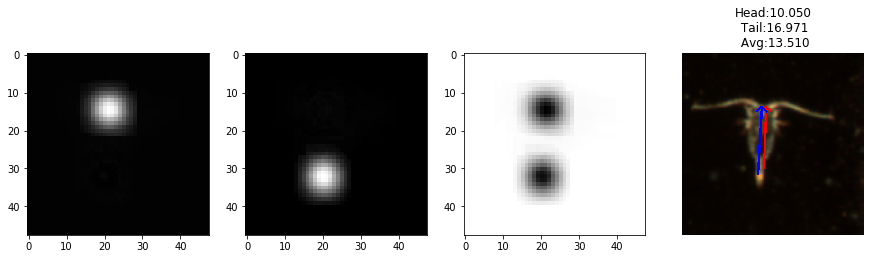

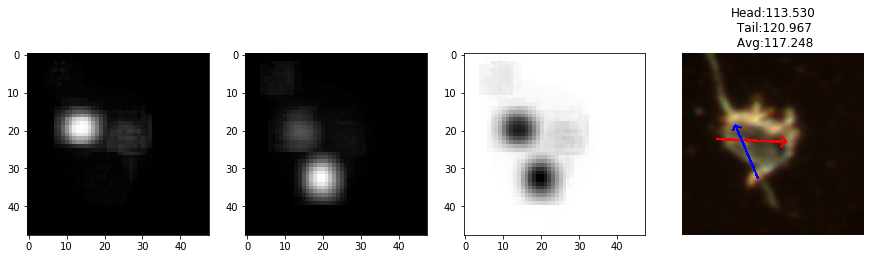

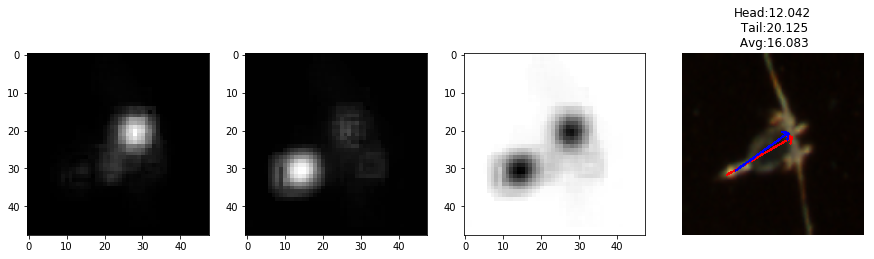

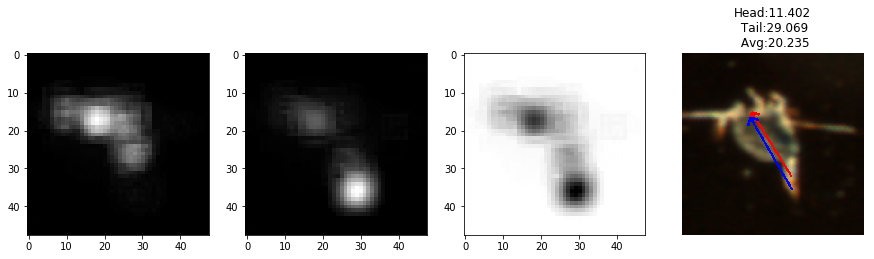

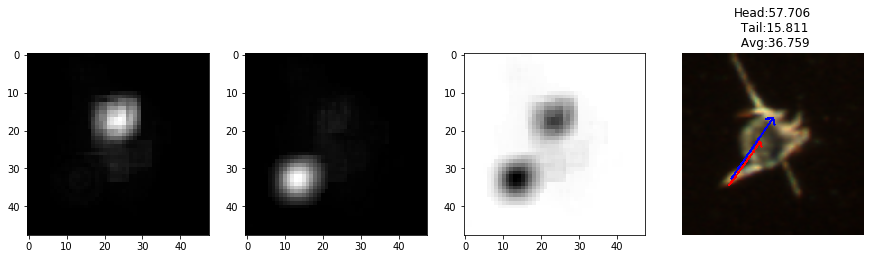

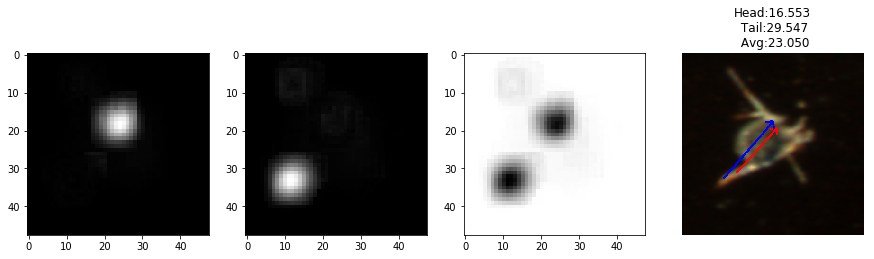

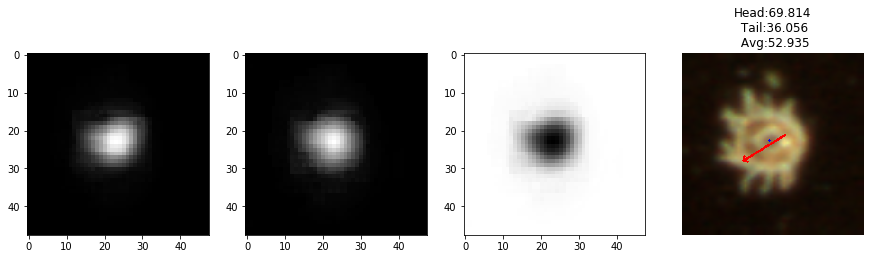

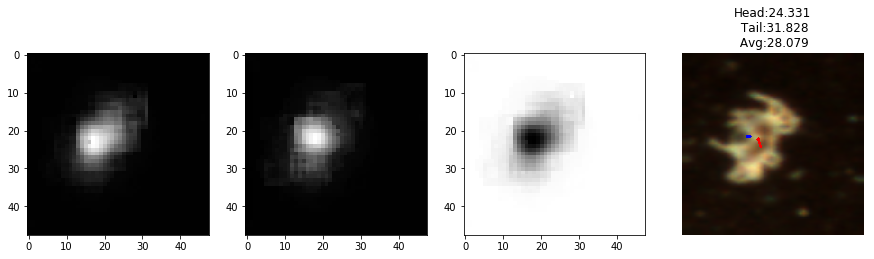

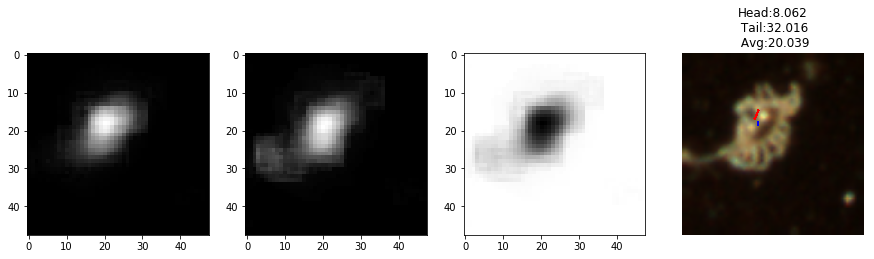

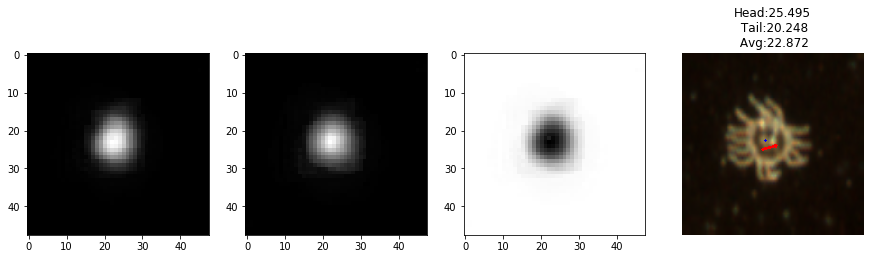

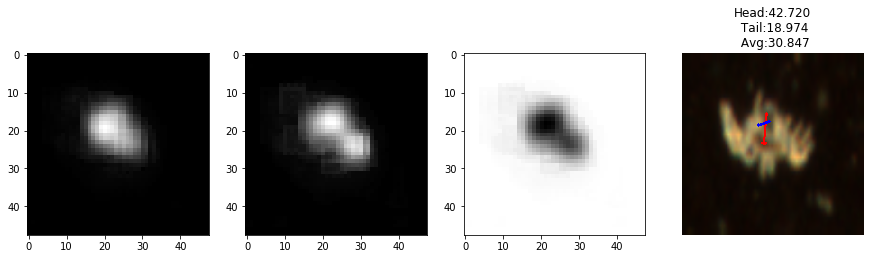

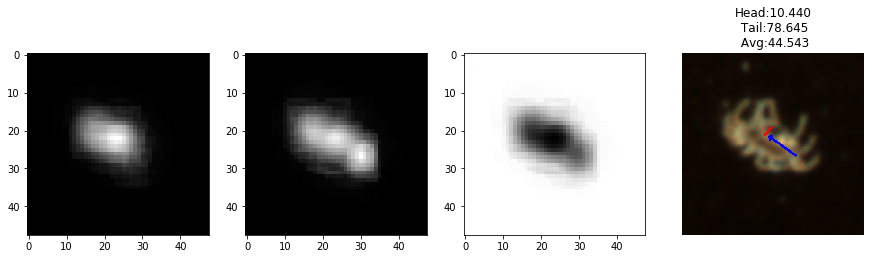

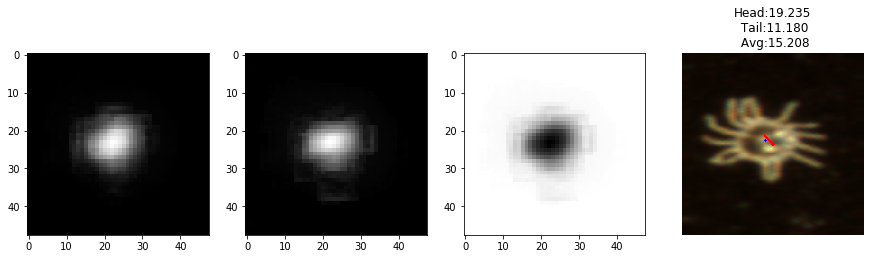

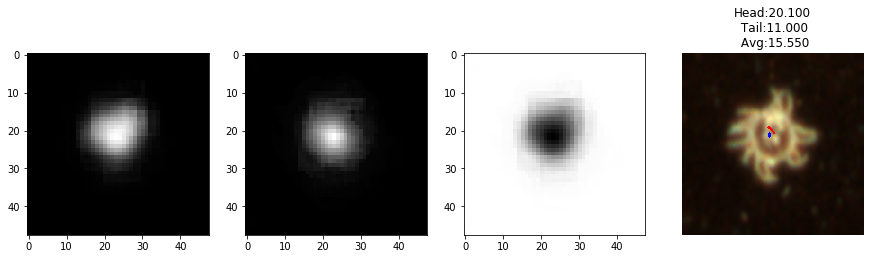

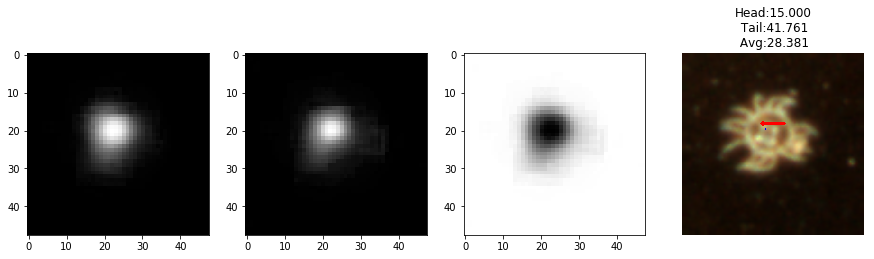

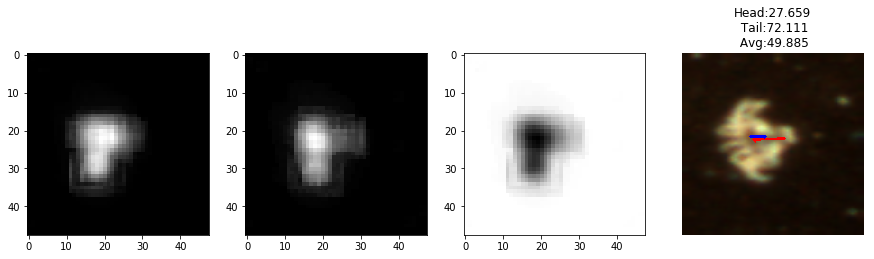

Process Process-2:
Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/plankton/miniconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/plankton/miniconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/home/plankton/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/plankton/miniconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/plankton/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/plankton/miniconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/home/plankton/miniconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.

KeyboardInterrupt: 

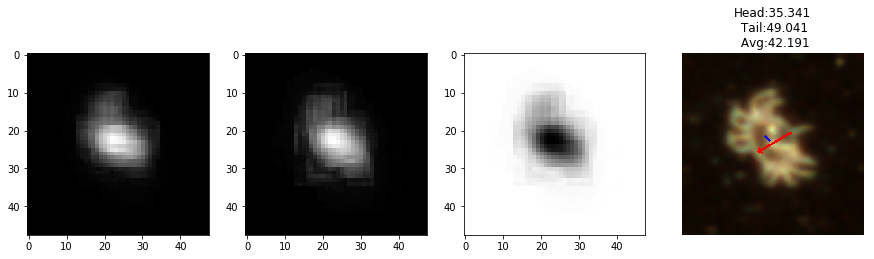

In [5]:
for j,data in enumerate(dataloaders['test']):
    model.eval()
    inputs, target, coordinates = data['image'], data['target_map'], data['coordinates']
    
    if use_gpu:
        inputs = Variable(inputs.cuda(_GPU))
        target = Variable(target.cuda(_GPU))
    else:
        inputs, target = Variable(inputs), Variable(target)
    
    outputs = model(inputs)
    pred_maps = outputs.cpu().data[0].numpy()
    
    fig, axarr = plt.subplots(1,4, figsize=(15,4))
    for i,pred_map in enumerate(pred_maps):
        axarr[i].imshow(pred_map, cmap='gray')
    poseCoords = np.stack([np.unravel_index(p.argmax(), p.shape) for p in pred_maps])/48.
    poseCoords = np.fliplr(poseCoords)

    data0 = normalize.recover(data)
    images = data0['image']
          
    evalShowArrow(images[0], poseCoords, coordinates[0], None)

In [55]:
poseCoords = pickle.load(open('predPose.p', "rb"))
print poseCoords[0]
poseCoords = [np.fliplr(i) for i in poseCoords]
poseCoords[0]

[[0.20833333 0.41666667]
 [0.66666667 0.33333333]
 [0.         0.97916667]]


array([[0.41666667, 0.20833333],
       [0.33333333, 0.66666667],
       [0.97916667, 0.        ]])

In [ ]:
def get_belief_map(model, image):
    batch_image = image.unsqueeze(0)
    return model(batch_image).data[0]